In [33]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy.io import loadmat
import visionloader as vl
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
from scipy.optimize import minimize, differential_evolution
import os
import src.fitting as fitting
import src.multielec_utils as mutils

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load in triplet stim elecResps and amplitudes

In [2]:
dataset = "2021-05-27-4/data003/"
electrical_path = "/Volumes/Analysis/" + dataset

In [3]:
vis_datapath = "/Volumes/Analysis/2021-05-27-4/data001"
vis_datarun = "data001"
vcd = vl.load_vision_data(
    vis_datapath,
    vis_datarun,
    include_neurons=True,
    include_ei=True,
    include_params=True,
    include_noise=True,
)

coords = vcd.get_electrode_map()

In [110]:
patterns = np.array([24])
n = 3711

In [111]:
all_elecs = []
neg_inds_total = 0
pos_inds_total = 0

for i in range(len(patterns)):
    p = patterns[i]
    print("Pattern " + str(p))
    filepath = (
        "/Volumes/Scratch/Users/praful/triplet_gsort_v2_30um_periphery-affinity/"
        + dataset
        + "p"
        + str(p)
        + "/"
    )

    triplet_elecs = mutils.get_stim_elecs_newlv(electrical_path, p)
    amplitudes = mutils.get_stim_amps_newlv(electrical_path, p)

    num_pts = len(amplitudes)

    triplet_probs = np.zeros(num_pts)
    for k in range(num_pts):
        with open(
            filepath
            + "gsort_tri_v2_n"
            + str(n)
            + "_p"
            + str(p)
            + "_k"
            + str(k)
            + ".pkl",
            "rb",
        ) as f:
            prob_dict = pickle.load(f)
            triplet_probs[k] = prob_dict["prob"]

    neg_inds = np.where((np.all(amplitudes < 0, axis=1)) & (triplet_probs > 0.08))[0]
    pos_inds = np.where((np.all(amplitudes > 0, axis=1)) & (triplet_probs > 0.08))[0]
    all_elecs.append(triplet_elecs)

    pos_inds_total += len(pos_inds)
    neg_inds_total += len(neg_inds)

Pattern 24


In [112]:
pos_inds_total, neg_inds_total

(13, 17)

In [113]:
all_elecs_array = np.unique(np.array(all_elecs))

In [114]:
all_elecs_array

array([189, 201, 203], dtype=uint8)

In [115]:
X_pos = []
y_pos = []

X_neg = []
y_neg = []

trials_pos = []
trials_neg = []

In [116]:
for i in range(len(patterns)):
    p = patterns[i]
    print("Pattern " + str(p))
    filepath = (
        "/Volumes/Scratch/Users/praful/triplet_gsort_v2_30um_periphery-affinity/"
        + dataset
        + "p"
        + str(p)
        + "/"
    )

    triplet_elecs = mutils.get_stim_elecs_newlv(electrical_path, p)
    amplitudes = mutils.get_stim_amps_newlv(electrical_path, p)

    num_pts = len(amplitudes)

    triplet_probs = np.zeros(num_pts)
    triplet_trials = np.zeros(num_pts, dtype=int)
    for k in range(num_pts):
        with open(
            filepath
            + "gsort_tri_v2_n"
            + str(n)
            + "_p"
            + str(p)
            + "_k"
            + str(k)
            + ".pkl",
            "rb",
        ) as f:
            prob_dict = pickle.load(f)
            triplet_probs[k] = prob_dict["prob"]
            triplet_trials[k] = prob_dict["num_trials"]

    neg_inds = np.where((np.all(amplitudes < 0, axis=1)) & (triplet_probs > 0.08))[0]
    pos_inds = np.where((np.all(amplitudes > 0, axis=1)) & (triplet_probs > 0.08))[0]

    elec_inds = np.searchsorted(all_elecs_array, triplet_elecs)

    y = triplet_probs[pos_inds]
    X = amplitudes[pos_inds]
    trials = triplet_trials[pos_inds]
    X_pos_p = np.zeros((len(pos_inds), len(all_elecs_array)))
    X_pos_p[:, elec_inds] = X
    X_pos.append(X_pos_p)
    y_pos.append(y)
    trials_pos.append(trials)

    y = triplet_probs[neg_inds]
    X = amplitudes[neg_inds]
    trials = triplet_trials[neg_inds]
    X_neg_p = np.zeros((len(neg_inds), len(all_elecs_array)))
    X_neg_p[:, elec_inds] = X
    X_neg.append(X_neg_p)
    y_neg.append(y)
    trials_neg.append(trials)

    print(all_elecs_array)
    print(triplet_elecs)
    print(elec_inds)
    print(amplitudes[neg_inds])
    print(X_neg_p)
    print(y)
    print(trials)

Pattern 24
[189 201 203]
[203 189 201]
[2 0 1]
[[-0.84375 -1.21875 -1.78125]
 [-0.65625 -1.03125 -1.59375]
 [-1.78125 -0.46875 -1.59375]
 [-1.78125 -1.78125 -0.28125]
 [-0.46875 -0.46875 -1.21875]
 [-1.03125 -1.59375 -1.03125]
 [-1.78125 -1.59375 -1.78125]
 [-1.21875 -0.09375 -1.59375]
 [-0.84375 -0.65625 -1.40625]
 [-1.78125 -0.46875 -1.59375]
 [-1.40625 -1.03125 -0.28125]
 [-1.40625 -0.84375 -0.65625]
 [-1.78125 -1.59375 -0.28125]
 [-1.21875 -0.65625 -1.03125]
 [-1.03125 -1.21875 -1.59375]
 [-0.65625 -1.40625 -1.78125]
 [-1.03125 -1.40625 -0.84375]]
[[-1.21875 -1.78125 -0.84375]
 [-1.03125 -1.59375 -0.65625]
 [-0.46875 -1.59375 -1.78125]
 [-1.78125 -0.28125 -1.78125]
 [-0.46875 -1.21875 -0.46875]
 [-1.59375 -1.03125 -1.03125]
 [-1.59375 -1.78125 -1.78125]
 [-0.09375 -1.59375 -1.21875]
 [-0.65625 -1.40625 -0.84375]
 [-0.46875 -1.59375 -1.78125]
 [-1.03125 -0.28125 -1.40625]
 [-0.84375 -0.65625 -1.40625]
 [-1.59375 -0.28125 -1.78125]
 [-0.65625 -1.03125 -1.21875]
 [-1.21875 -1.59375 -1

In [117]:
all_amps_neg = np.vstack(X_neg)
all_probs_neg = np.hstack(y_neg)
trials_neg = np.hstack(trials_neg)

In [118]:
all_amps_pos = np.vstack(X_pos)
all_probs_pos = np.hstack(y_pos)
trials_pos = np.hstack(trials_pos)

In [119]:
all_amps_neg

array([[-1.21875, -1.78125, -0.84375],
       [-1.03125, -1.59375, -0.65625],
       [-0.46875, -1.59375, -1.78125],
       [-1.78125, -0.28125, -1.78125],
       [-0.46875, -1.21875, -0.46875],
       [-1.59375, -1.03125, -1.03125],
       [-1.59375, -1.78125, -1.78125],
       [-0.09375, -1.59375, -1.21875],
       [-0.65625, -1.40625, -0.84375],
       [-0.46875, -1.59375, -1.78125],
       [-1.03125, -0.28125, -1.40625],
       [-0.84375, -0.65625, -1.40625],
       [-1.59375, -0.28125, -1.78125],
       [-0.65625, -1.03125, -1.21875],
       [-1.21875, -1.59375, -1.03125],
       [-1.40625, -1.78125, -0.65625],
       [-1.40625, -0.84375, -1.03125]])

In [120]:
all_amps_pos.shape, all_probs_pos.shape, trials_pos.shape

((13, 3), (13,), (13,))

In [121]:
train_amps_pos, test_amps_pos, train_probs_pos, test_probs_pos, train_trials_pos, _ = train_test_split(all_amps_pos, all_probs_pos, trials_pos, test_size=0.2)
train_amps_neg, test_amps_neg, train_probs_neg, test_probs_neg, train_trials_neg, _ = train_test_split(all_amps_neg, all_probs_neg, trials_neg, test_size=0.2)

In [148]:
degree = 1
multi_X, multi_y = fitting.convertToBinaryClassifier(
    train_probs_neg, train_trials_neg, train_amps_neg, degree
)

In [149]:
multi_X.shape, multi_y.shape

((291, 4), (291,))

In [150]:
mu = np.concatenate((np.array([1]), np.zeros(multi_X.shape[-1] - 1)))
multi_results = minimize(fitting.negLL, x0=mu, args=(multi_X, multi_y, False, "none"))
multi_weights = multi_results.x

In [151]:
multi_weights

array([ 0.5254282 ,  1.21386828,  0.92897619, -0.9921508 ])

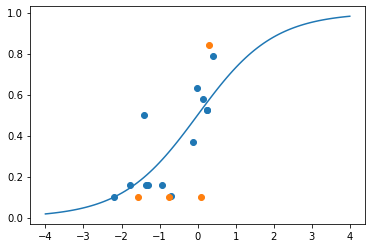

In [152]:
poly = PolynomialFeatures(degree)
test_X = poly.fit_transform(test_amps_neg)
test_y = test_probs_neg

train_X = poly.fit_transform(train_amps_neg)
train_y = train_probs_neg

plt.scatter(train_X @ multi_weights, train_y)
plt.scatter(test_X @ multi_weights, test_y)
sigmoid_x = np.linspace(-4, 4, 100)
plt.plot(sigmoid_x, 1 / (1 + np.exp(-sigmoid_x)))

In [153]:
degree = 1
multi_X, multi_y = fitting.convertToBinaryClassifier(
    train_probs_pos, train_trials_pos, train_amps_pos, degree
)

In [154]:
multi_X.shape, multi_y.shape

((191, 4), (191,))

In [155]:
mu = np.concatenate((np.array([1]), np.zeros(multi_X.shape[-1] - 1)))
multi_results = minimize(fitting.negLL, x0=mu, args=(multi_X, multi_y, False, "none"))
multi_weights = multi_results.x

In [156]:
multi_weights

array([-3.37048015,  0.98258001,  0.48103451,  0.93289226])

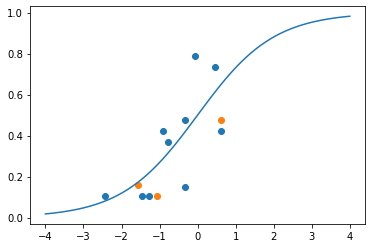

In [157]:
poly = PolynomialFeatures(degree)
test_X = poly.fit_transform(test_amps_pos)
test_y = test_probs_pos

train_X = poly.fit_transform(train_amps_pos)
train_y = train_probs_pos

plt.scatter(train_X @ multi_weights, train_y)
plt.scatter(test_X @ multi_weights, test_y)
sigmoid_x = np.linspace(-4, 4, 100)
plt.plot(sigmoid_x, 1 / (1 + np.exp(-sigmoid_x)))